# Manuscript Revision R2

Decision received 7 November 2016. Response requested within 30 days.

In [1]:
import itertools

In [73]:
import math

In [2]:
import matplotlib

In [3]:
matplotlib.use('Agg')

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt

In [6]:
import os

In [7]:
import pandas as pd

In [8]:
import random

## Reviewer 2

"...There must be something trivial about the seed sets that are clustered so tightly around AUC=0.5. Even in the case of random classifiers, I think one would expect more variation about the AUC=0.5 point than is observed here, which would suggest to me there is something unexpected driving these results. One other possibility that comes to mind—does this relate to the size of the gene set?  E.g. are these all of the size 2 gene sets?"

**2016 November 20-21, December 1**

Plot the AUC against seed set size for *H. sapiens*:

In [9]:
os.chdir(os.path.join('..', 'src'))

In [10]:
import func_net_pred

In [11]:
organism = 'sapiens'
biogridpath, fnetpath = func_net_pred.setup_filepaths(organism)
funcNetDf = pd.read_pickle(fnetpath)
numNodes = len(funcNetDf.columns)
geneExample = funcNetDf.columns[0]
colName = func_net_pred.determine_col(organism, geneExample)

Create a plotting function that accepts the genetic interaction type as an argument:

In [12]:
def plot_sizes(intactType):
    seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
    seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)
    AUCs = [t[0] for t in seedAUC]
    seedSetSizes = [len(seed2intacts[t[1]]) for t in seedAUC]
    plt.scatter(seedSetSizes, AUCs, marker='x')
    plt.ylim(0.0, 1.05)
    plt.xlabel('Seed set size', fontsize='large')
    plt.ylabel('AUC', fontsize='large')
    plt.title('Human {}'.format(intactType), fontsize='x-large')
    plt.grid(b=True)
    plt.tight_layout()
    plt.show()

First, consider phenotypic enhancement:

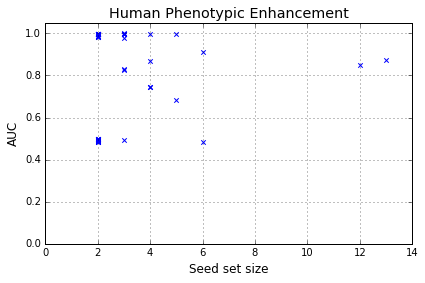

In [13]:
plot_sizes('Phenotypic Enhancement')

Next, phenotypic suppression:

In [14]:
plot_sizes('Phenotypic Suppression')

**2016 December 1**

Create box and whisker plot for seed set size of 2.

In [64]:
def bimodal_boxwhisker(intactType):
    seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
    seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)
    AUCs = [t[0] for t in seedAUC]
    seedSetSizes = [len(seed2intacts[t[1]]) for t in seedAUC]
    
    randAUCsize2 = [x for x, y in zip(AUCs, seedSetSizes) if x < 0.55 and y == 2]
    nonrandAUCsize2 = [x for x, y in zip(AUCs, seedSetSizes) if x > 0.55 and y == 2]
    
    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(4, 4))

    # plot the same data on both axes
    ax.boxplot(nonrandAUCsize2)
    ax2.boxplot(randAUCsize2)

    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(0.97, 1.0)
    ax2.set_ylim(0.48, 0.5)

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop='off')  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    d = .015  # how big to make the diagonal lines in axes coordinates
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    fig.text(-0.05, 0.5, 'AUC', va='center', rotation='vertical', fontsize='x-large')
    fig.suptitle('Human {}'.format(intactType), fontsize='x-large')
    labels = [item.get_text() for item in ax2.get_xticklabels()]
    labels[0] = 'Seed set size = 2'
    ax2.set_xticklabels(labels, fontsize='x-large')

    plt.show()

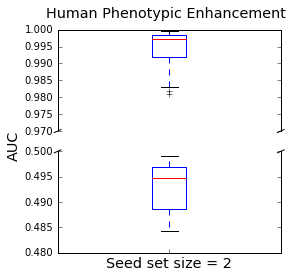

In [65]:
bimodal_boxwhisker('Phenotypic Enhancement')

In [66]:
bimodal_boxwhisker('Phenotypic Suppression')

**2016 December 1**

Also plot the data only for random AUC.

In [82]:
def rand_auc_dist(intactType):
    seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
    seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)
    AUCs = [t[0] for t in seedAUC]
    seedSetSizes = [len(seed2intacts[t[1]]) for t in seedAUC]
    
    randAUCandSize = [(x, y) for x, y in zip(AUCs, seedSetSizes) if x < 0.55]
    randAUC, randSizes = zip(*randAUCandSize)
    
    plt.scatter(randAUC, randSizes, s=80, facecolors='None', edgecolors='b')
    plt.xlabel('AUC', fontsize='large')
    plt.ylabel('Seed Set Size', fontsize='large')
    plt.title('Human {}'.format(intactType), fontsize='x-large')
    plt.ylim(ymin = 0)
    plt.grid(True)
    # Be sure to only pick integer tick locations.
    for axis in [plt.gca().get_yaxis()]:
        axis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    plt.show()

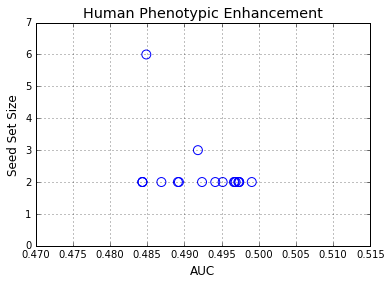

In [83]:
rand_auc_dist('Phenotypic Enhancement')

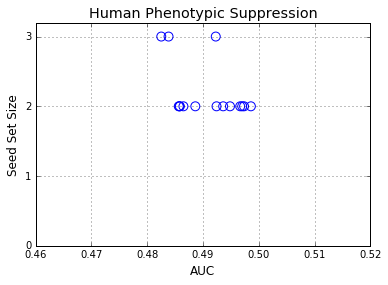

In [84]:
rand_auc_dist('Phenotypic Suppression')

**2016 November 28, December 1**

An additional approach to addressing the reviewer's concern is to scramble the genetic interaction associations. This would show that the high AUC signal is indeed due to clustering in the functional network and not the effect of seed set size. Gather all the genetic interaction partners into a single set and for each seed gene, randomly choose a set of the same size as the actual number of interaction partners. 

In [15]:
def scramble_interactions(intactType):
    seedSets = func_net_pred.read_biogrid(biogridpath, intactType, colName)
    seedAUC, seed2intacts = func_net_pred.seed_set_predictability(funcNetDf, seedSets)
    allPartners = set(itertools.chain.from_iterable(seed2intacts.values()))
    rand2intacts = dict()
    for seed in seed2intacts.keys():
        rand2intacts[seed] = random.sample(allPartners, len(seed2intacts[seed]))
    randAUC, _ = func_net_pred.seed_set_predictability(funcNetDf, rand2intacts)
    func_net_pred.plot_aucs(randAUC, '{} (randomized)'.format(intactType))

As above, consider phenotypic enhancement and suppression in human:

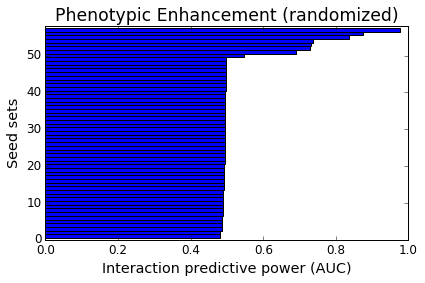

In [16]:
scramble_interactions('Phenotypic Enhancement')

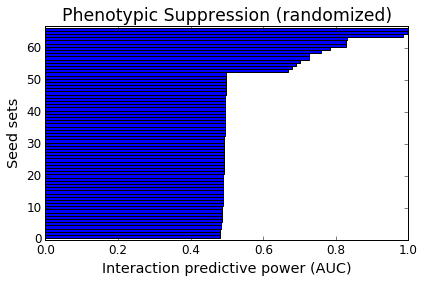

In [17]:
scramble_interactions('Phenotypic Suppression')